In [20]:
ls


mm/  sample_data/


1555640767
1555640777
dict_keys(['loss', 'acc', 'binary_crossentropy', 'val_loss', 'val_acc', 'val_binary_crossentropy']) 

(196, 7)



,loss,acc,binary_crossentropy,val_loss,val_acc,val_binary_crossentropy,epoch
191,0.040094,0.98805,0.040094,0.035027,0.9920,0.035027,191
192,0.040437,0.98780,0.040437,0.034645,0.9921,0.034645,192
193,0.039813,0.98745,0.039813,0.034599,0.9925,0.034599,193
194,0.039450,0.98810,0.039450,0.034484,0.9913,0.034484,194
195,0.039548,0.98770,0.039548,0.034046,0.9925,0.034046,195


5000/5000 [==============================] - 0s 23us/sample - loss: 0.0340 - acc: 0.9925 - binary_crossentropy: 0.0340
[0.034046190930902956, 0.9925, 0.034046188]
5000/5000 [==============================] - 0s 43us/sample - loss: 0.0340 - acc: 0.9925 - binary_crossentropy: 0.0340
[0.034046190930902956, 0.9925, 0.034046188]
- h5 networks filesize is :  37.84375  kbytes
CPU times: user 13.3 s, sys: 480 ms, total: 13.8 s
Wall time: 14.1 s


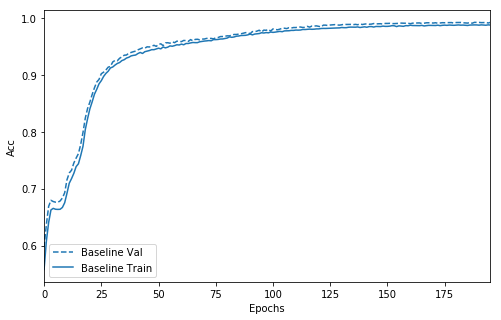

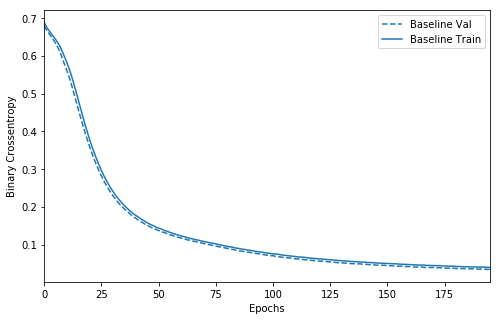

In [2]:
%%time 

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep 
from IPython.display import display

### lib_



def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(8,5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key], '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

def norm_x_y_data(X_train, X_test):
    #import sklearn.preprocessing as prep 
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    # X_train_R0=preprocessor.inverse_transform(X_test)    
    return [X_train, X_test]

def show_predict(y_test, y_label, y_predict):
    cnt_err = 0
    for i in range(len(y_test)):
        if np.argmax(y_label[i]) != np.argmax(y_predict[i]):
            print (y_test[i])
            print (y_label[i] , " vs " , y_predict[i])
            e_ =  y_test[i]
            print ("- diff is :" , np.abs(np.sqrt(e_[0] * e_[0] + e_[-1] * e_[-1]) - 0.66))
            cnt_err += 1
            print()
    print("- cnt error is ", cnt_err)
    print()

def get_mm_filesize(param_num):
    R0 = 33.9765625
    each_size = 0.01171875
    return R0 + param_num * each_size 

def gen_model(x_dim, y_dim):
#     baseline_model.compile(optimizer='adam',
#                        loss='binary_crossentropy',
#                        metrics=['accuracy', 'binary_crossentropy'])    


    baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
        keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(x_dim,)),
        keras.layers.Dense(8, activation=tf.nn.relu),
    #     keras.layers.Dropout(0.2),
        keras.layers.Dense(y_dim, activation=tf.nn.sigmoid) ])
    
    
#     baseline_model.summary()
#     opt = tf.train.AdamOptimizer(learning_rate=0.001)
    
    baseline_model.compile(
        optimizer=tf.keras.optimizers.Adam(),

                loss=tf.keras.losses.binary_crossentropy,
                metrics=['accuracy','binary_crossentropy'])
    
    
    return baseline_model    

def gen_train_label(rows, x_dim, y_dim):
    x_train = np.random.random([rows,x_dim])
    x_label = np.random.random([rows,y_dim])
    x_label.fill(0.0)

    for idx in range(rows):
        e_ = x_train[idx]

        e_c = (np.sqrt(e_[0] * e_[0] + e_[-1] * e_[-1]) > 0.66) * 1.0
        x_label[idx][int(e_c)] = 1.0

    return [x_train, x_label]



if __name__ == "__main__":
#     !perl -e "print time"
    import os
    if not os.path.exists("./mm"):
        !mkdir  mm
        !ls mm
    
    
    rows = 10000
    x_dim = 10
    y_dim = 2    
    

    key_acc = "acc"
    
    if "WINDIR" in os.environ :
        key_acc = "accuracy"  # my windows   
        
#     if "HOME" in os.environ and os.environ["HOME"] == "/home/bgi902":
#         key_acc = "accuracy"
    
        

    [x_train, x_label] = gen_train_label(rows, x_dim, y_dim)
    [y_test, y_label] = gen_train_label( int(rows/2), x_dim, y_dim)
#     [x_train, y_test] = norm_x_y_data(x_train, y_test)
    baseline_model = gen_model(x_dim, y_dim)
    

    early_stop = keras.callbacks.EarlyStopping(monitor="val_" + key_acc,  patience=7)
    !perl -e "print time"
    print()
    baseline_history = baseline_model.fit(x_train,
                                      x_label,
                                      epochs=300,
                                      batch_size=1000,
                                      validation_data=(y_test, y_label),
                                      callbacks=[early_stop],
                                      verbose=0)    
    
    !perl -e "print time"
    print()

    plot_history( [ ('baseline', baseline_history) ], key=key_acc) # may be "acc" if gpu
    plot_history( [ ('baseline', baseline_history) ], key="binary_crossentropy")
    
    print(baseline_history.history.keys(), "\n")

    # history to DF
    baseline_history_ = pd.DataFrame(baseline_history.history)
    baseline_history_['epoch'] = baseline_history.epoch
    print(baseline_history_.shape)
    print()
    display(baseline_history_.tail())
    
    
    batch_size = 1000
    s_i = np.random.choice(range(len(y_test)), batch_size)
    y_predict = baseline_model.predict(y_test[s_i])
#     show_predict(y_test[s_i], y_label[s_i], y_predict)
    
    print (baseline_model.evaluate(y_test, y_label))
    

    if 1:
        baseline_model.save('./mm/h5.h5')
        baseline_model_new_h5 = tf.keras.models.load_model('./mm/h5.h5')
        #     baseline_model_new_h5.summary()
        print (baseline_model_new_h5.evaluate(y_test, y_label))

    if 0:
        baseline_model.save_weights('./mm/ckpt')
        baseline_model_new_ckp = gen_model(x_dim, y_dim)
        #     baseline_model_new_ckp.summary()
        baseline_model_new_ckp.load_weights('./mm/ckpt')
        print (baseline_model_new_ckp.evaluate(y_test, y_label))
        baseline_model_new_ckp.summary()

    print ("- h5 networks filesize is : " , get_mm_filesize(baseline_model.count_params()) , " kbytes")

### lib_ end







32768/30286 [================================] - 0s 2us/step
Instructions for updating:
Use tf.cast instead.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
...........................................................................................

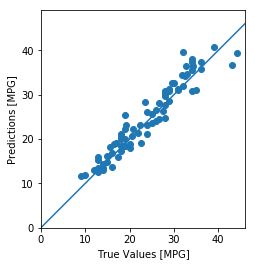


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  Tr

In [13]:
%%time
# jd add



#   import list
import numpy as np
import pandas as pd
import tensorflow as tf  # tf version = 2.0.0-alpha. with keras
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep 
#

np.mat("1,2,3;1,5,6")


dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.isna().sum()
dataset = dataset.dropna()
dataset.isna().sum()
dataset.tail(11)
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

train_dataset = dataset.sample(frac=0.8, random_state=0)
train_dataset.shape
test_dataset = dataset.drop(train_dataset.index)
test_dataset.shape

# see the table's dist
# sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("MPG")

train_stats = train_stats.transpose()
train_stats


train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
test_labels.tail()


preprocessor = prep.StandardScaler().fit(train_dataset.values)
mycl = train_dataset.columns
np_normed_train_data = preprocessor.transform(train_dataset.values)
np_normed_test_data = preprocessor.transform(test_dataset.values)

normed_train_data = pd.DataFrame(np_normed_train_data, columns=mycl)
normed_test_data = pd.DataFrame(np_normed_test_data, columns=mycl)

# print(normed_train_data)




def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# normed_train_data = norm(train_dataset)
# normed_train_data.tail()["Cylinders"].loc[281]   # 0.307
# normed_test_data = norm(test_dataset)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])


  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
 # print(model.batch_size)
  print()
  return model

model = build_model()

model.summary()
normed_train_data.tail()


# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 300

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.shape)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


# plot_history(history)
# -----------------------------
# -----------------------------

model_early_stop = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=11)

history_early_stop = model_early_stop.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# plot_history(history_early_stop)

hist_early_stop = pd.DataFrame(history_early_stop.history)
hist_early_stop['epoch'] = history_early_stop.epoch
print(hist_early_stop.shape)


loss, mae, mse = model_early_stop.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Std Error: {:5.2f} MPG".format(mse))

test_predictions = model_early_stop.predict(normed_test_data).flatten()
# print(test_predictions)

print(type(test_labels))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - test_labels
if 0:
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")

# Save weights to a TensorFlow Checkpoint file
model_early_stop.save_weights('./mm/my_model')


# Restore the model's state,
# this requires a model with the same architecture.
reload_model = build_model()

reload_model.load_weights('./mm/my_model')
reload_model.summary()

reload_test_predictions = reload_model.predict(normed_test_data).flatten()
# print(test_predictions)
print (reload_test_predictions == test_predictions)


model_early_stop.save('./mm/h5.h5')
h5_reload_model = tf.keras.models.load_model('./mm/h5.h5')
h5_reload_model.summary()
h5_reload_test_predictions = h5_reload_model.predict(normed_test_data).flatten()
# print(test_predictions)
print (h5_reload_test_predictions == test_predictions)

# !date "+%Y%m%d_%H%M%S"
# jd end